In [31]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact

In [38]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
m_sc=3*hwc #1e2*meV
mu_sc=0*hwc #1e2*meV
nu=0.#sqrt(2)+0.1
m_n= 0.1*hwc
mu_n=nu*hwc #10*meV
ky_sw=np.linspace(-3,10,50)/lB


Ls=6*lB
Lx=8*lB
Nx=200
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])

Hx= hbar*vF*np.kron(np.diag(kx) , sigma1)
HeB= -2*vF*elec*B* np.kron(np.real(y1(k1-k2)), sigma2)
HeBT= -2*vF*elec*B* np.kron(np.real(y1(k2-k1)), sigma2)

Hxm= np.kron( y0s(k1-k2) , m_sc*sigma3)+ np.kron( 2*np.real(y0(k1-k2)) , m_n*sigma3)
Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2), sigma0 )

Vn=np.zeros((2*Nx,2*Nx,len(ky_sw)), dtype=np.complex64)
En=np.zeros((2*Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy= np.kron(hbar*vF*ky*np.eye(Nx), sigma2)

    H_t = Hx +Hy + HeB + Hxm + Hef    
    En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)

print("Done!")

Done!


In [44]:
def wf_real_space(ev,k,x,Lx):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1]) #*np.sqrt(x[1]-x[0]),
    return np.dot(np.exp(1j*kt*xt),ev[0:2*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev[1:2*Nx:2,:])/np.sqrt(2*Lx)*np.sqrt(x[1]-x[0])

def plot_wf(i_band=Nx,
            iwf=int(3*len(ky_sw)/4)):
# iwf=0
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(ky_sw*lB,En.T/hwc,'b')
    plt.plot(ky_sw[iwf]*lB,En[i_band,iwf]/hwc,'ro')
    plt.ylabel("Energy(meV)")
    plt.xlabel("X(l)")
    plt.ylim(-2,2)
    # plt.xlim(-7.5,7.5)
    plt.grid()
#     plt.show()

    x0=np.linspace(-1,1,500)*12*lB
    wf_a,wf_b=wf_real_space(np.reshape(Vn[:,i_band,:],[2*Nx,len(ky_sw)]),kx,x0,Lx)
#     plt.figure()
    plt.subplot(2,1,2)
    plt.plot(x0/lB,np.abs(wf_a[:,iwf])**2,label=r'$eA\uparrow$')
    plt.plot(x0/lB,np.abs(wf_b[:,iwf])**2,label=r'$eB\uparrow$')
    plt.title('ky=%.2f' % (ky_sw[iwf]*lB) )
    plt.legend()
#     plt.ylim(0,8e7)
    plt.show()

In [45]:
interact(plot_wf,iwf=(0,len(ky_sw)-1,1), i_band=range(Nx-int(nu**2)-1,Nx+int(nu**2)+1));
#, continuous_update=False);

interactive(children=(Dropdown(description='i_band', index=1, options=(199, 200), value=200), IntSlider(value=…

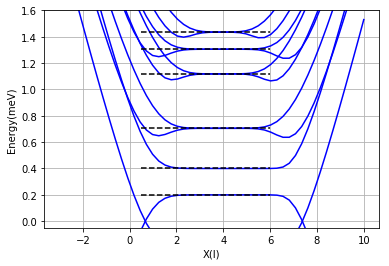

In [42]:
gn=0.3
plt.figure()
# plt.plot(ky_sw/1e9,En.T/meV)
plt.plot(ky_sw*lB,En.T/hwc+gn,'b')
plt.plot(ky_sw*lB,En.T/hwc-gn,'b')
plt.ylabel("Energy(meV)")
# plt.xlabel("ky(1/nm)")

Nll=4
ill=np.arange(Nll)
E1=np.reshape(np.sqrt(ill+(m_n/hwc)**2),[1,Nll])
Eplot= np.concatenate((E1,E1),axis=0)
xvals=np.reshape(np.array([0.5,6]),[2,1])
plt.plot(xvals, Eplot-gn,'k--')
plt.plot(xvals, Eplot+gn,'k--')
plt.plot(xvals, -Eplot-gn,'k--')
plt.plot(xvals, -Eplot+gn,'k--')


plt.xlabel("X(l)")
plt.ylim(-0.05,1.6)
# plt.xlim(-7.5,7.5)
plt.grid()
plt.show()



In [ ]:
a=np.reshape(range(4),[2,2])
b=np.reshape(range(4,8),[2,2])
Hd=sigma2+1j*sigma3
x=block_diag(a,b)+np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)+np.kron(np.array([[0.,0.],[1.0,0.]]),np.transpose(Hd).conj())
print(x)

In [ ]:
print(D_sc/meV)